# Group knockoff vs regular knockoffs power

In [ ]:
# ml julia/1.8.4
# export JULIA_DEPOT_PATH="/home/groups/sabatti/.julia"

using Knockoffs
using LinearAlgebra
using Random
using StatsBase
using Statistics
using Distributions
using DataFrames, CSV
using DelimitedFiles
using GLM

BLAS.set_num_threads(1)

function run_group_knockoff(seed::Int, method::String, use_reps::Bool, block_size::Int)
    simdir = "/home/groups/sabatti/group_knockoff_simulations/compute_time/block$(block_size)"
    outdir = joinpath(simdir, "sim$seed")
    isdir(outdir) || mkpath(outdir)

    if block_size == 1 && method == "sdp"
        method = "sdp_ccd" # use coordinate descent rather than solver for single knockoffs
    end

    # parameters
    m = 5
    ps = [50, 100, 500, 1000, 2500, 5000]
    df = DataFrame(method=String[], p50=Float64[], p100=Float64[], p500=Float64[],
        p1000=Float64[],p2500=Float64[],p5000=Float64[])

    timings = zeros(length(ps))
    for (idx, p) in enumerate(ps)
        # simulate Σ
        Random.seed!(seed)
        Σ = simulate_AR1(p, a=3, b=1)

        # define group membership (every block_size variables form a group)
        groups = zeros(Int, p)
        i, group = 1, 1
        while i ≤ p
            for j in 1:block_size
                groups[i] = group
                i += 1
                i > p && break
            end
            group += 1
        end

        # solve knockoff problem
        my_t = @elapsed begin
            try
                if use_reps
                    group_reps = choose_group_reps(Symmetric(Σ), groups)
                    _, _, obj = solve_s_graphical_group(Symmetric(Σ), groups, group_reps, Symbol(method), m=m)
                else
                    _, _, obj = solve_s_group(Symmetric(Σ), groups, Symbol(method), m=m, verbose=true)
                end
            catch e
                flush(stdout)
                showerror(stdout, e)
                println("errored for p = $p")
            end
        end
        timings[idx] = my_t
        println("p $p: timing = $my_t")
        flush(stdout)
    end
    push!(df, [method timings'])
    outfile = use_reps ? "r$method.csv" : "$method.csv"
    CSV.write(joinpath(outdir, outfile), df)
end

# seed = 1
# method = "sdp"
# use_reps = false
# block_size = 2

seed = parse(Int, ARGS[1])
method = ARGS[2]
use_reps = parse(Bool, ARGS[3])
block_size = parse(Int, ARGS[4])
run_group_knockoff(seed, method, use_reps, block_size)

submission scripts

In [10]:
function run_repeats(userep::Bool)
    outdir = "/home/groups/sabatti/group_knockoff_simulations"
    ko_methods = ["equi", "sdp", "maxent", "mvr"]
    for sim in 1:25, method in ko_methods, bs in [1, 2, 5, 10]
        # check if job is finished (optional)
#         outfile = joinpath(outdir, "compute_time/block$bs/sim$sim/$method.csv")
#         isfile(outfile) && continue
        # create .sh file to submit jobs
        filename = "submit.sh"
        open(filename, "w") do io
            println(io, "#!/bin/bash")
            println(io, "#")
            println(io, "#SBATCH --job-name=time$sim")
            println(io, "#")
            println(io, "#SBATCH --time=168:00:00")
            println(io, "#SBATCH --cpus-per-task=1")
            println(io, "#SBATCH --mem-per-cpu=8G")
            println(io, "#SBATCH --partition=candes,zihuai")
            println(io, "#SBATCH --output=$(outdir)/compute_time/slurms/slurm-%j.out")
            println(io, "")
            println(io, "#save job info on joblog:")
            println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
            println(io, "")
            println(io, "# load the job environment:")
            println(io, "module load julia/1.8.4")
            println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
            println(io, "")
            println(io, "# run code")
            println(io, "echo 'julia $(outdir)/run_benchmarks.jl $sim $method $userep $bs'")
            println(io, "julia $(outdir)/run_benchmarks.jl $sim $method $userep $bs")
            println(io, "")
            println(io, "#echo job info on joblog:")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
            println(io, "#echo \" \"")
        end
        # submit job
        run(`sbatch $filename`)
        println("submitted sim$sim block $bs with $method") 
        rm(filename, force=true)
    end
end
for use_rep in [true, false]
    run_repeats(use_rep)
end


Submitted batch job 20254686
submitted sim1 block 10 with sdp
Submitted batch job 20254688
submitted sim1 block 10 with maxent
Submitted batch job 20254689
submitted sim1 block 10 with mvr
Submitted batch job 20254690
submitted sim2 block 2 with sdp
Submitted batch job 20254692
submitted sim2 block 5 with sdp
Submitted batch job 20254694
submitted sim2 block 10 with sdp
Submitted batch job 20254695
submitted sim2 block 10 with maxent
Submitted batch job 20254696
submitted sim3 block 5 with sdp
Submitted batch job 20254699
submitted sim3 block 10 with sdp
Submitted batch job 20254700
submitted sim3 block 10 with maxent
Submitted batch job 20254703
submitted sim4 block 10 with sdp
Submitted batch job 20254704
submitted sim5 block 10 with sdp
Submitted batch job 20254705
submitted sim5 block 10 with maxent
Submitted batch job 20254706
submitted sim5 block 10 with mvr
Submitted batch job 20254707
submitted sim6 block 5 with sdp
Submitted batch job 20254708
submitted sim6 block 10 with sdp


## Make plots

In [13]:
using ProgressMeter
using DataFrames, CSV
using Plots
using LinearAlgebra
using Statistics
gr(fmt=:png);

global my_colors = ["gold", "orangered2", "mediumblue", "cyan3"]

# note: don't include timing for p = 50 since that's for warming up Julia
function summarize_timings(block::Int, method, ps = [100, 500, 1000, 2500, 5000])
    dir = "/home/groups/sabatti/group_knockoff_simulations/compute_time"
    times = zeros(length(ps))
    success = 0
    for seed in 1:100
        try
            result = CSV.read(joinpath(dir, "block$block", "sim$seed", "$method.csv"), DataFrame)
            times .+= result[1, 3:end] |> Vector
            success += 1
        catch
            continue
        end
    end
    @show success
    times ./= success
    return times
end

function make_plot_timings(block::Int, use_reps::Bool)
    if block == 1
        ko_methods = use_reps ? ["requi", "rsdp_ccd", "rmaxent", "rmvr"] : ["equi", "sdp_ccd", "maxent", "mvr"]
    else
        ko_methods = use_reps ? ["requi", "rsdp", "rmaxent", "rmvr"] : ["equi", "sdp", "maxent", "mvr"]
    end
    ko_labels = use_reps ? ["rEqui", "rSDP", "rME", "rMVR"] : ["Equi", "SDP", "ME", "MVR"]
    ps = [100, 500, 1000, 2500, 5000]

    my_xtick = use_reps ? ([100, 1000, 5000], ["100", "1000", "5000"]) : ([100, 1000, 5000], ["", "", ""]) 
    my_ylim = (1e-3, 5e5)
    my_xlim = (90, 6e3)
    xlabels = use_reps ? "Dimension (p)" : ""

    if block == 1
        my_ytick = [1e-3, 1e-1, 1e1, 1e3, 1e5]
        my_title = use_reps ? "" : "Group size $block"
        timing_plt = plot(; title=my_title, framestyle = :box,size=(500,500), 
            xaxis=:log, yaxis=:log, xtick=my_xtick, ytick=my_ytick,
            xlabel=xlabels, left_margin=20Plots.mm, ylim=my_ylim, xlim=my_xlim,
            ylabel="Time (sec)", legend=false, titlefontsize=10)

        # add annotation
        annotate_ypos = use_reps ? 10 : 50
        annotate_text = use_reps ? "Con. Ind. Group Knockoffs" : "Group Knockoffs"
        annotate!(timing_plt, 15, annotate_ypos, Plots.text(annotate_text, :black, rotation = 90, 11))
    elseif block == 2
        my_ytick = ([1e-3, 1e-1, 1e1, 1e3, 1e5], ["","","","",""])
        my_title = use_reps ? "" : "Group size $block"
        timing_plt = plot(; title=my_title, xaxis=:log, yaxis=:log, ylim=my_ylim, xlim=my_xlim,
            xtick=my_xtick, xlabel=xlabels, legend=false, titlefontsize=10, size=(500,500), 
            framestyle = :box, ytick=my_ytick)
    elseif block == 5
        my_ytick = ([1e-3, 1e-1, 1e1, 1e3, 1e5], ["","","","",""])
        my_title = use_reps ? "" : "Group size $block"
        timing_plt = plot(; title=my_title, xaxis=:log, yaxis=:log,ylim=my_ylim, xlim=my_xlim,
            xtick=my_xtick, xlabel=xlabels, legend=false, titlefontsize=10, size=(500,500), 
            framestyle = :box, ytick=my_ytick)
    else
        my_ytick = ([1e-3, 1e-1, 1e1, 1e3, 1e5], ["","","","",""])
        my_title = use_reps ? "" : "Group size $block"
        timing_plt = plot(; title=my_title, xaxis=:log,yaxis=:log,ylim=my_ylim, xlim=my_xlim,
            xtick=my_xtick, xlabel=xlabels, legend=false, titlefontsize=10, size=(500,500),
            framestyle = :box, ytick=my_ytick)
    end
    
    # loop over knockoff results
    for (i, method) in enumerate(ko_methods)
        label = ko_labels[i]
        times = summarize_timings(block, method)
        plot!(timing_plt, ps, times, label=label, w=3, color=my_colors[i], markershape=:circle)
    end
    hline!(timing_plt, [60], label = "1 minute", linestyle=:dot, w=2, alpha=0.15, color=:black)
    hline!(timing_plt, [3600], label = "1 hour", linestyle=:dot, w=2, alpha=0.25, color=:black)
    hline!(timing_plt, [36000], label = "10 hours", linestyle=:dot, w=2, alpha=0.5, color=:black)
    if block == 5
        annotate!(timing_plt, 200, 110, Plots.text("1 minute", :black, 8, rotation = 0))
        annotate!(timing_plt, 180, 6600, Plots.text("1 hour", :black, 8, rotation = 0))
        annotate!(timing_plt, 200, 66000, Plots.text("10 hours", :black, 8, rotation = 0))
    end
    
    return timing_plt
end

make_plot_timings (generic function with 1 method)

success = 25
success = 25
success = 25
success = 25
success = 25
success = 25
success = 25
success = 25
success = 25
success = 23
success = 25
success = 25
success = 25
success = 20
success = 20
success = 19
success = 25
success = 25
success = 25
success = 25
success = 25
success = 25
success = 25
success = 25
success = 25
success = 25
success = 25
success = 25
success = 25
success = 25
success = 25
success = 25


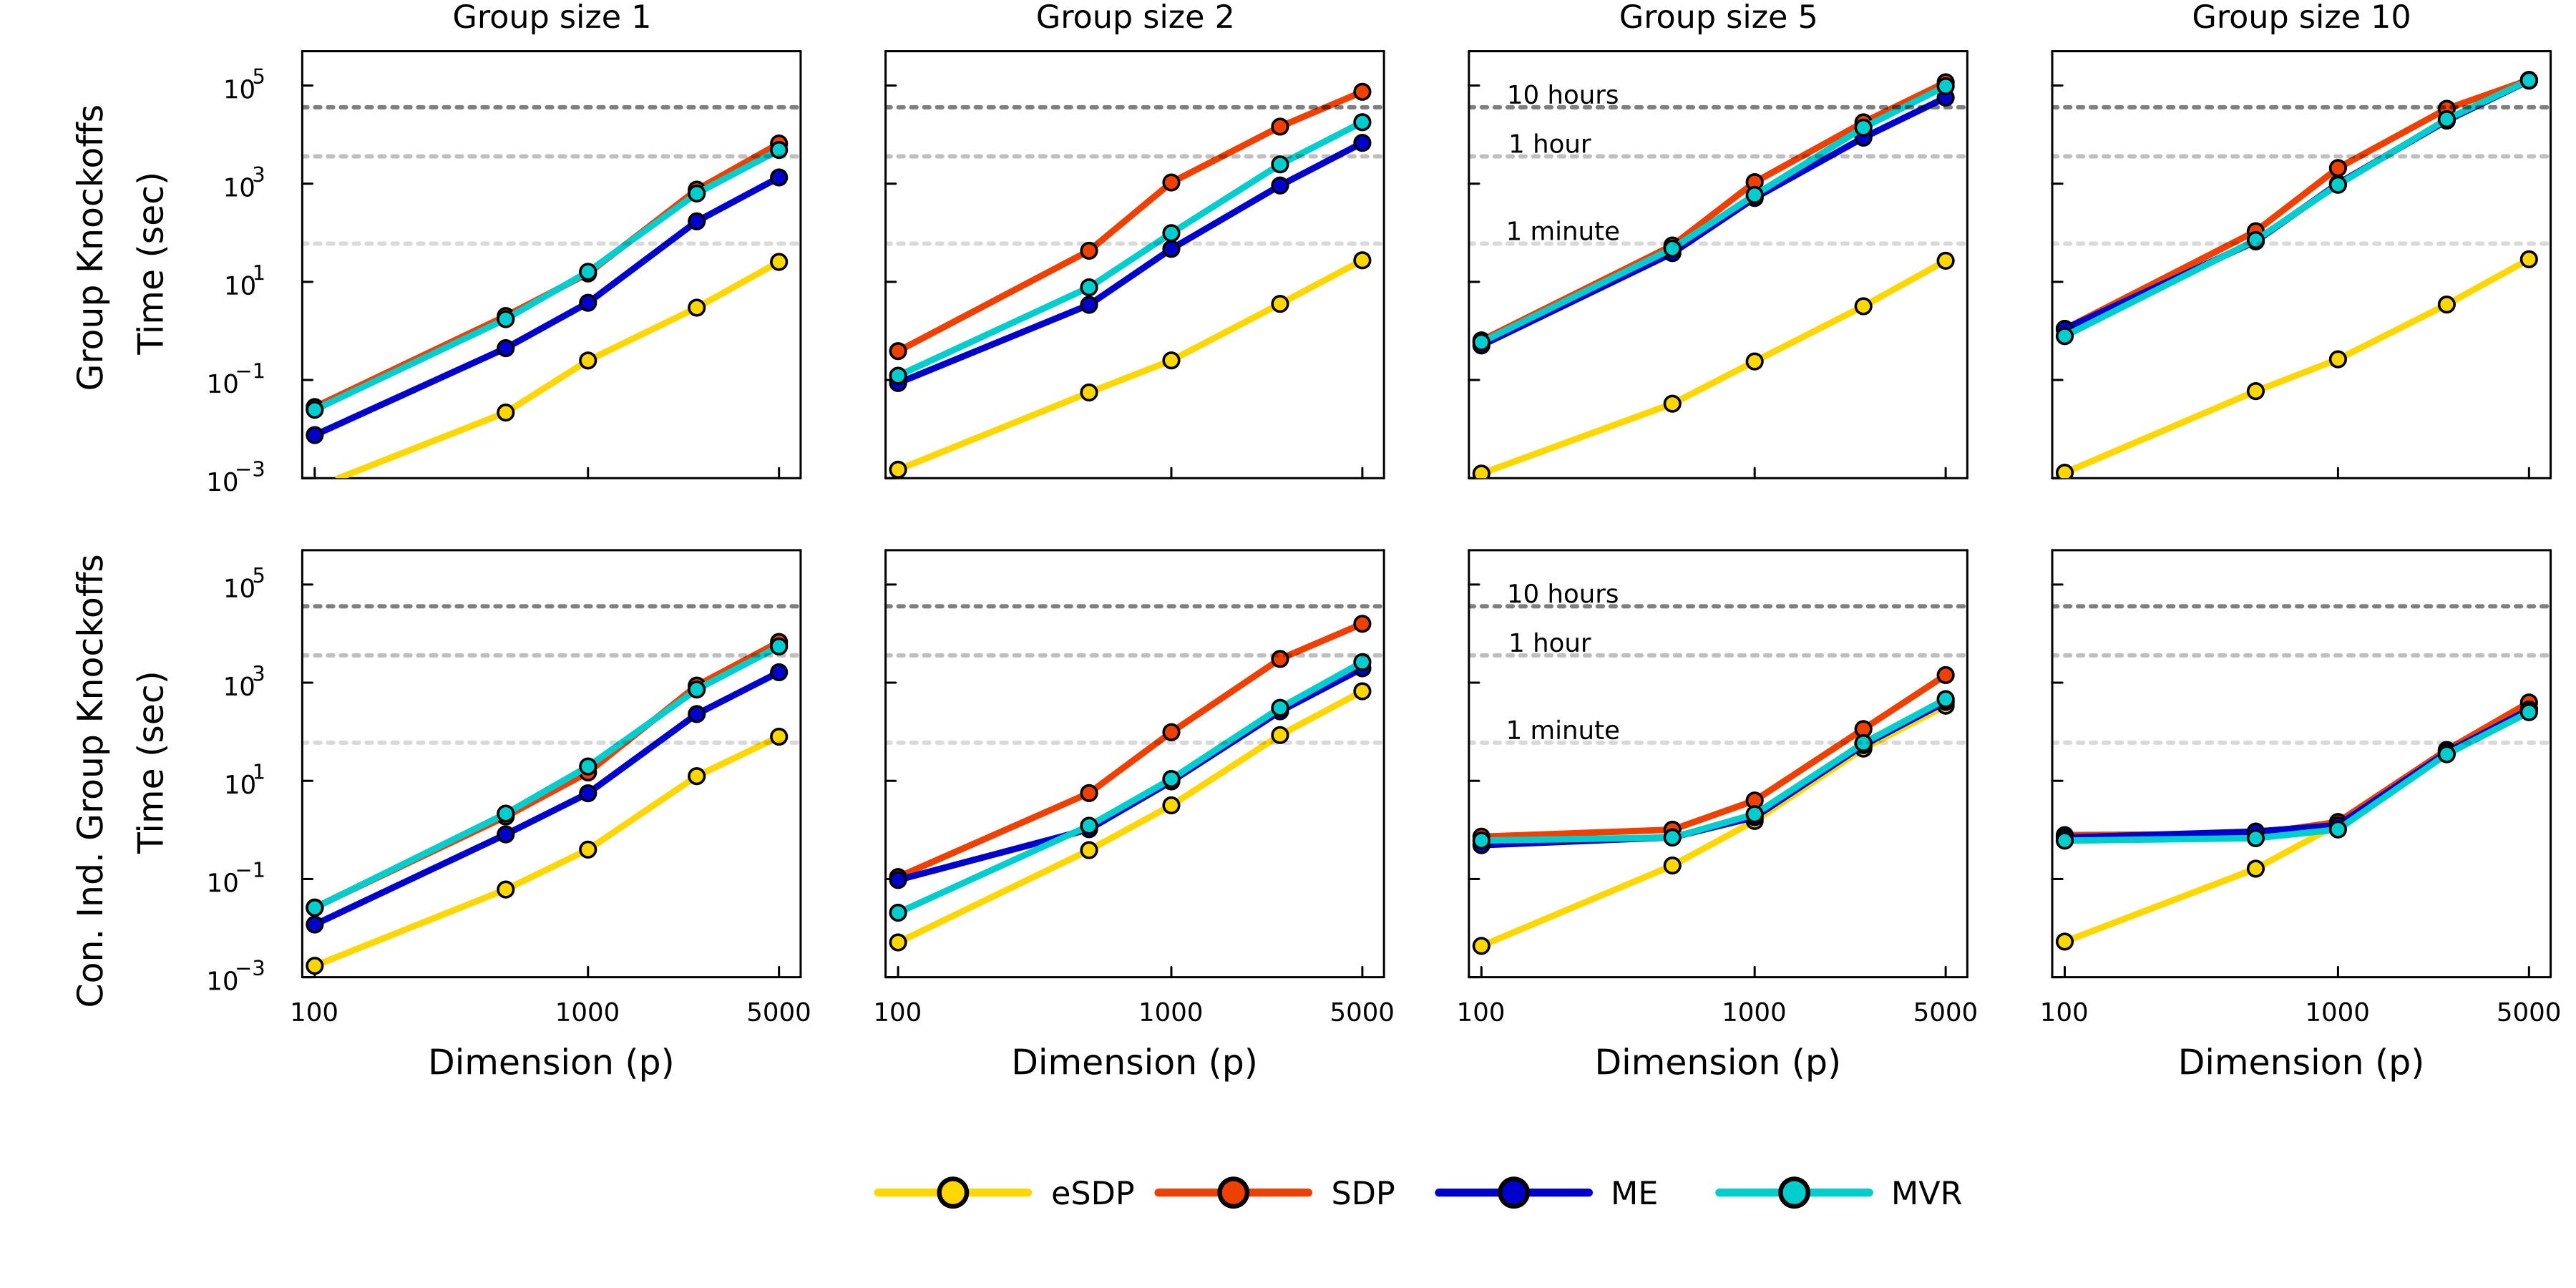

┌ Warning: n° of legend_column=6 is larger than n° of series=4
└ @ Plots /home/groups/sabatti/.julia/packages/Plots/7XeYS/src/backends/gr.jl:1235


In [14]:
#
# group knockoff plot
#
use_reps = false
plt = []
for blocksize in [1, 2, 5, 10]
    push!(plt, make_plot_timings(blocksize, use_reps))
end
GK_plt = plot(plt..., xgrid=false, ygrid=false, layout=(1, 4))

#
# rep group knockoff plot
#
use_reps = true
plt = []
for blocksize in [1, 2, 5, 10]
    push!(plt, make_plot_timings(blocksize, use_reps))
end
rGK_plt = plot(plt..., xgrid=false, ygrid=false, layout=(1, 4), bottom_margin=5Plots.mm)

#
# separate legend plot
#
n = 6
shapes = [:circle :circle :circle :circle]
labels = ["eSDP" "SDP" "ME" "MVR"]
lstyles = [:solid :solid :solid :solid]
legend_plt = plot(2:n,2:n, lims=(0,1), legendfontsize=10, legend=:outerbottom, w=3,
    legendcolumns=n, frame=:none, fg_color_legend = nothing, 
    label=labels[1], color=my_colors[1], markershapes=shapes[1], linestyle=lstyles[1])
plot!(legend_plt, 2:n, 2:n, label=labels[2], color=my_colors[2], markershapes=shapes[2], w=3,linestyle=lstyles[2])
plot!(legend_plt, 2:n, 2:n, label=labels[3], color=my_colors[3], markershapes=shapes[3], w=3,linestyle=lstyles[3])
plot!(legend_plt, 2:n, 2:n, label=labels[4], color=my_colors[4], markershapes=shapes[4], w=3,linestyle=lstyles[4])
# plot!(legend_plt, 2:n, 2:n, label="1h", color="black", alpha=0.3, w=2, linestyle=:dot)
# plot!(legend_plt, 2:n, 2:n, label="10h", color="black", alpha=0.7, w=2, linestyle=:dot)

#
# combine GK, rGK, and legend plots
#
combined_plt = plot(GK_plt, rGK_plt, layout=(2, 1))
final_plt = plot(combined_plt, legend_plt, size=(1200, 600), 
    layout = grid(2, 1, heights=[0.9, 0.1]), dpi=300)

In [15]:
savefig(final_plt, "/home/users/bbchu/knockoffs/plots/timings.pdf")

┌ Warning: n° of legend_column=6 is larger than n° of series=4
└ @ Plots /home/groups/sabatti/.julia/packages/Plots/7XeYS/src/backends/gr.jl:1235


"/home/users/bbchu/knockoffs/plots/timings.pdf"

# Timings for simulation 1

Figure 1 explored the power/FDR on 5 simulated covariances using eSDP/SDP/ME/MVR solvers with $p=1000$ and groups defined empirically on the design matrix. Here we compute the average times for those simulations.

In [1]:
using DataFrames
using CSV
using LinearAlgebra
using Statistics

In [63]:
mean_df = DataFrame("model"=>String[],"eSDP"=>Float64[],"SDP"=>Float64[],"ME"=>Float64[],"MVR"=>Float64[])
std_df = DataFrame("model"=>String[],"eSDP"=>Float64[],"SDP"=>Float64[],"ME"=>Float64[],"MVR"=>Float64[])

# each simulation has results stored differently
result_dirs1 = ["/home/groups/sabatti/group_knockoff_simulations/block_cov/vary_n/n1000"]
result_dirs2 = [
    "/home/groups/sabatti/group_knockoff_simulations/ER_cov/n1000",
    "/home/groups/sabatti/group_knockoff_simulations/ER_prec/n1000",
]
result_dirs3 = [
    "/home/groups/sabatti/group_knockoff_simulations/AR1",
    "/home/groups/sabatti/group_knockoff_simulations/AR1_corr",
]


# block cov result
cov = "block_cov"
dir = result_dirs1[1]
my_times = Vector{Float64}[]
idx = [1, 4, 2, 3]
for sim in 1:100
    result = CSV.read(joinpath(dir, "sim$sim.csv"), DataFrame)
    push!(my_times, result[idx, "time"])
end
my_times = hcat(my_times...)
push!(mean_df, vcat(cov, mean(my_times, dims=2)))
push!(std_df,  vcat(cov, std(my_times, dims=2)))


# ER results
covs = ["ER_cov", "ER_prec"]
for (cov, dir) in zip(covs, result_dirs2)
    my_times = Vector{Float64}[]
    for sim in 1:100
        result = CSV.read(joinpath(dir, "sim$sim.csv"), DataFrame)
        push!(my_times, result[!, "time"])
    end
    my_times = hcat(my_times...)
    push!(mean_df, vcat(cov, mean(my_times, dims=2)))
    push!(std_df,  vcat(cov, std(my_times, dims=2)))
end


# AR1 results
for dir in result_dirs3
    my_times = Vector{Float64}[]
    for sim in 1:100
        result = CSV.read(joinpath(dir, "sim$sim", "n1000.csv"), DataFrame)
        push!(my_times, result[!, "time"])
    end
    my_times = hcat(my_times...)
    push!(mean_df, vcat(basename(dir), mean(my_times, dims=2)))
    push!(std_df,  vcat(basename(dir), std(my_times, dims=2)))
end
mean_df

Row,model,eSDP,SDP,ME,MVR
,String,Float64,Float64,Float64,Float64
1,block_cov,4.13819,244.246,18.8288,33.5698
2,ER_cov,2.80767,3858.23,157.766,124.32
3,ER_prec,3.8213,6738.13,69.0455,91.9662
4,AR1,3.9512,668.843,56.8675,92.6085
5,AR1_corr,4.28412,973.257,172.447,225.41


In [64]:
std_df

Row,model,eSDP,SDP,ME,MVR
,String,Float64,Float64,Float64,Float64
1,block_cov,0.482468,141.187,4.05865,5.85571
2,ER_cov,0.364058,1035.75,47.0845,38.9439
3,ER_prec,0.530159,1755.93,17.9237,26.3947
4,AR1,1.24412,418.259,32.8996,51.3605
5,AR1_corr,1.30526,579.992,105.997,132.904


In [74]:
for row in 1:5
    for col in 1:5
        if col == 1
            print(mean_df[row, col])
        elseif col == 5
            print(" & \$", round(mean_df[row, col], digits=1), " \\pm ", round(std_df[row, col], digits=1), "\$\\\\", "\n")
        else
            print(" & \$", round(mean_df[row, col], digits=1), " \\pm ", round(std_df[row, col], digits=1), "\$")
        end
    end
end

block_cov & $4.1 \pm 0.5$ & $244.2 \pm 141.2$ & $18.8 \pm 4.1$ & $33.6 \pm 5.9$\\
ER_cov & $2.8 \pm 0.4$ & $3858.2 \pm 1035.7$ & $157.8 \pm 47.1$ & $124.3 \pm 38.9$\\
ER_prec & $3.8 \pm 0.5$ & $6738.1 \pm 1755.9$ & $69.0 \pm 17.9$ & $92.0 \pm 26.4$\\
AR1 & $4.0 \pm 1.2$ & $668.8 \pm 418.3$ & $56.9 \pm 32.9$ & $92.6 \pm 51.4$\\
AR1_corr & $4.3 \pm 1.3$ & $973.3 \pm 580.0$ & $172.4 \pm 106.0$ & $225.4 \pm 132.9$\\
